# APS - Python para Ciência de Dados
## Grupo 7

**Integrantes**: Gustavo Luchesi, Max Mittledorf, Pedro Marino e Victor Alves

# Sobre a base de dados
Decidiu-se por utilizar dados referentes à performance de estudantes secundaristas de duas escolas portuguesas. Os dados contém informações à respeito dos estudantes e de suas famílias, além de seus desempenhos em matemática e língua portuguesa. Há duas bases de dados: uma para as notas de matemática e outra para as de português.

Neste trabalho vamos focar nas notas de matemática.

Os dados podem ser obtidos através do seguinte link: https://archive.ics.uci.edu/ml/datasets/Student+Performance

**Citação da base dados**: P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7. 

### Importando a base de dados

In [26]:
import pandas as pd 
import numpy as np
import patsy
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [27]:
math = pd.read_csv("data/student-mat.csv", sep=";")
port = pd.read_csv("data/student-por.csv", sep=";")

In [28]:
theme_set(theme_bw());

# Análise Exploratória

Para realizar a análise da base que utilizamos no projeto, focamos em algumas variáveis que, segundo a literatura acadêmica, possuem uma correlação com o desempenho escolar dos alunos. Dessa forma, olhamos para o sexo, características familiares e sociais dos alunos e para seus locais de residência de forma a entender como os dados se comportavam. A base com o desempenho em matemática é composta por 395 alunos e possui, em sua maioria, variáveis categóricas ou binárias.

In [29]:
math.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


## Distribuição das notas

Vamos começar observando as distribuições das notas finais de matemática dos alunos

### Todos os alunos

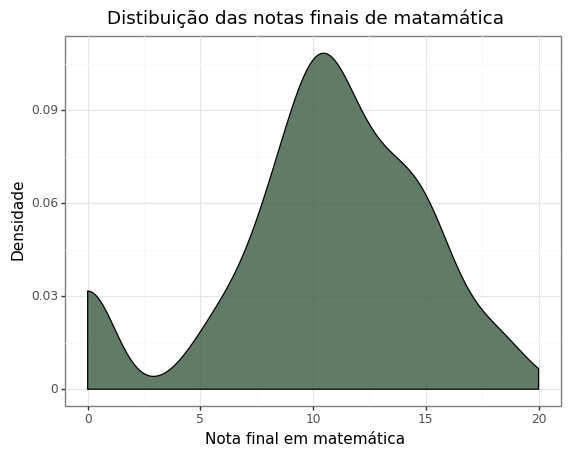

<ggplot: (328906734)>

In [30]:
(math
 .pipe(lambda _: ggplot(_) +
      geom_density(mapping=aes(x="G3"), fill="#3a5a40", alpha = 0.8) +
      theme_bw() +
      labs(title = "Distibuição das notas finais de matamática",
           x = "Nota final em matemática",
           y = "Densidade")))

As notas finais de matemática apresentam uma distribuição bastante curiosa. Há uma certa concentração de notas iguais a 0 e uma grande concentração de notas próximas à média de aprovação (que é igual a 10). Muito provavelmente, alunos que já estavam reprovados no terceiro trimestre nem se prestaram a fazer a prova final, o que explica essa concentração de notas iguais a 0.

### Divisão por sexo

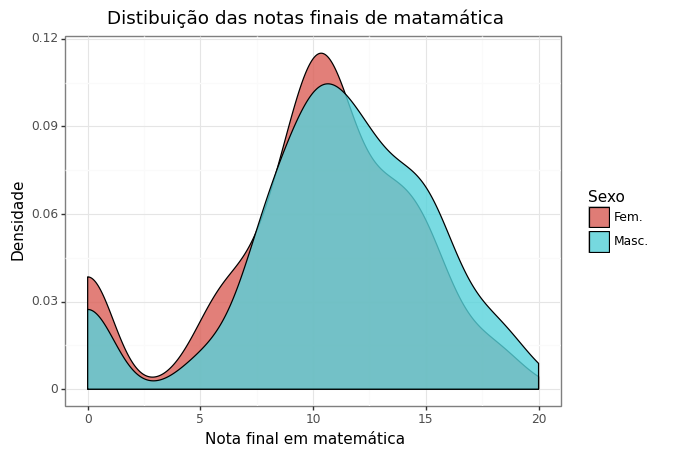

<ggplot: (328932740)>

In [31]:
(math
 .pipe(lambda _: ggplot(_) +
      geom_density(mapping=aes(x="G3", fill="sex"), alpha = 0.8) +
      theme_bw() +
      labs(title = "Distibuição das notas finais de matamática",
           x = "Nota final em matemática",
           y = "Densidade",
           fill="Sexo")+
      scale_fill_discrete(labels=["Fem.", "Masc."])))

Podemos ver que as distribuições são bastantes similares, muito embora os alunos do sexo masculino aparentem ter notas ligeiramente superiores em matemática

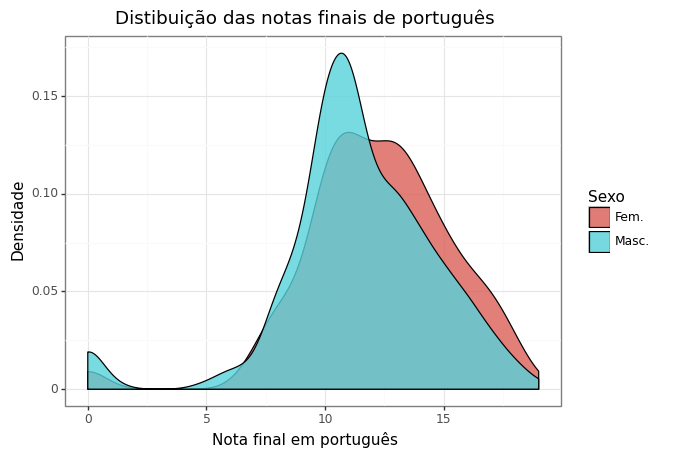

<ggplot: (328897512)>

In [32]:
(port
 .pipe(lambda _: ggplot(_) +
      geom_density(mapping=aes(x="G3", fill="sex"), alpha = 0.8) +
      theme_bw() +
      labs(title = "Distibuição das notas finais de português",
           x = "Nota final em português",
           y = "Densidade",
           fill="Sexo") +
           scale_fill_discrete(labels=["Fem.", "Masc."])))

Para as notas de português, podemos ver que o cenário é invertido: as alunas apresentam notas ligeiramente superiores aos alunos

### Divisão por realização de aulas complementares

Vamos observar agora como estão distribuídas as notas de alunos que realizam ou não realizam aulas complementare de matemática:

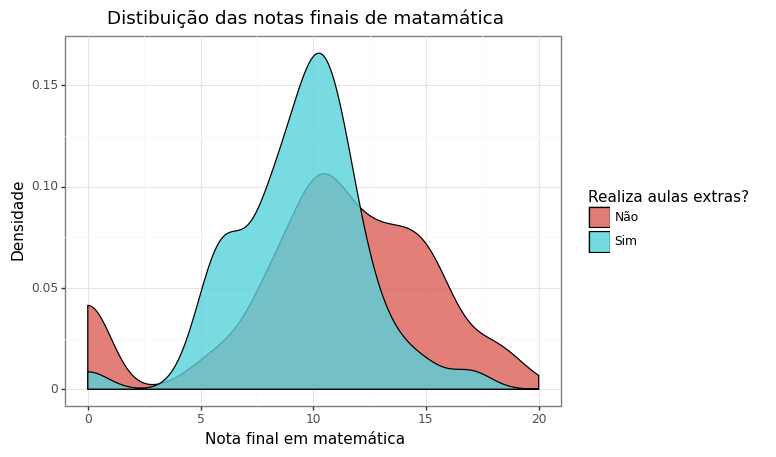

<ggplot: (329169761)>

In [33]:
(math
 .pipe(lambda _: ggplot(_) +
      geom_density(mapping=aes(x="G3", fill="schoolsup"), alpha = 0.8) +
      theme_bw() +
      labs(title = "Distibuição das notas finais de matamática",
           x = "Nota final em matemática",
           y = "Densidade",
           fill="Realiza aulas extras?") +
           scale_fill_discrete(labels=["Não", "Sim"])))

É bastante curioso notar que alunos que realizam aulas suplementares de matemática apresentam notas piores que os que não realizam. Isso sugere que os alunos que realizam essas aulas, o fazem por conta de suas deficiências na disciplina. 

## Relação entre localização da residência e desempenho

Algumas variáveis da base indicam características a cerca da localidade em que o aluno mora. Uma delas se trata da distância que o aluno mora da escola, em termos do tempo de deslocamento que é necessário para que ele chegue na escola, e a outra indica se ele mora em uma região rural ou urbana. Quanto à primeira variável, consideramos a hipótese de que o tempo que o aluno leva para chegar ao colégio possivelmente afeta o desempenho acadêmico dele/a, uma vez que tempos maiores de deslocamento podem levar a maior cansaço/stress ou podem ser um motivo para que o aluno falte mais às aulas. De fato, a "distância da escola" é uma característica muitas vezes utilizada como variável instrumental para número de faltas em aplicações empíricas de economia. Quanto à segunda variável, imaginamos que o fato de um aluno viver em uma localidade rural pode também estar correlacionado com maior dificuldade de deslocamento para o colégio ou com características da população local (menor escolaridade, por exemplo) que afetem seus resultados acadêmicos.

Olhando para a distribuição do número de faltas por tempo de deslocamento, percebe-se que há diferenças na distribuição de aulas perdidas considerando a distância que os alunos moram da escola. Mais especificamente, é possível observar que, quanto maior o tempo para chegar ao colégio, maior é a concentração em números mais elevados de faltas durante o ano letivo.

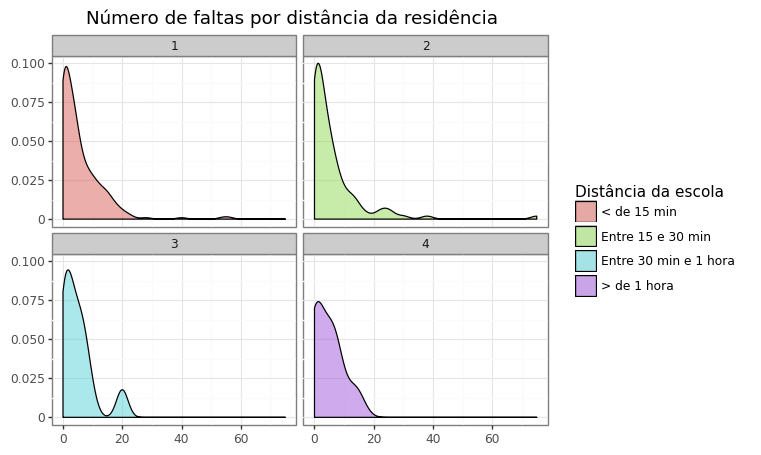

<ggplot: (329199430)>

In [34]:
math["traveltime"] = pd.Categorical(math.traveltime)

(
    ggplot(math) +
     geom_density(aes(x = "absences", fill = "traveltime"), alpha = 0.5) +
     facet_wrap("~ traveltime") +
     labs(x = "", y = "", title = "Número de faltas por distância da residência", fill = "Distância da escola") +
     scale_fill_discrete(labels = ["< de 15 min", "Entre 15 e 30 min", "Entre 30 min e 1 hora", "> de 1 hora"])
)

Olhando para a mesma distribuição, mas com uma visualização em gráfico de violino, percebe-se mais facilmente como a distribuição é mais concentrada em número de faltas levemente mais altos quanto mais tempo o aluno leva para chegar na escola (apesar de haverem alguns outliers no grupo de alunos que leva menos de 15 minutos para chegar).

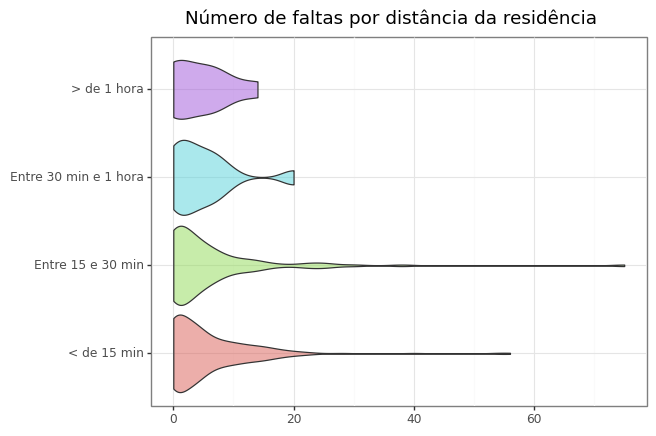

<ggplot: (328786758)>

In [35]:
(
    ggplot(math) +
     geom_violin(aes(y = "absences", x = "traveltime", fill = "traveltime"), alpha = 0.5) +
     labs(x = "", y = "", title = "Número de faltas por distância da residência", fill = "Distância da escola") +
     scale_x_discrete(labels = ["< de 15 min", "Entre 15 e 30 min", "Entre 30 min e 1 hora", "> de 1 hora"]) +
     theme(legend_position = "none") +
     coord_flip()
)

Dessa forma, encontramos o que parece ser uma correlação positiva entre tempo de deslocamento e número de faltas. Todavia, seria possível dizer que esse número maior de faltas leva mesmo a um desempenho pior? Observando o gráfico de dispersão abaixo, parece realmente haver uma correlação entre maior número de faltas e um pior desempenho em matemática. Interessante notar que essa relação negativa se verifica em ambas as escolas utilizadas para a coleta da base.

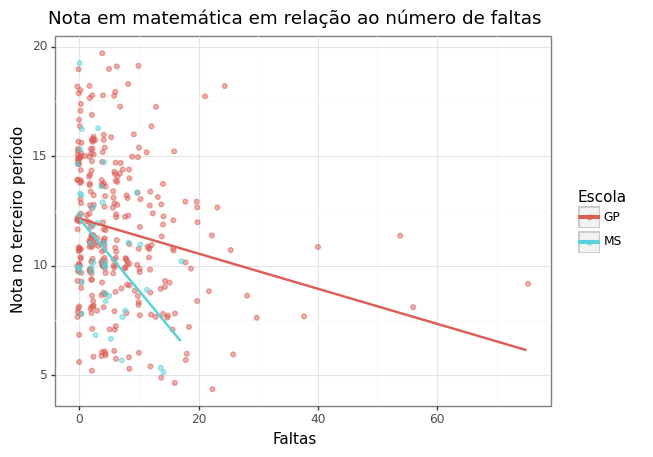

<ggplot: (328443298)>

In [36]:
math_filtered = math.query("G3 != 0")

(
    ggplot(math_filtered,
        aes(x = "absences", y = "G3", color = "school")) +
     geom_point(alpha = 0.5, position = "jitter") +
     geom_smooth(method = "lm", se = False) +
     labs(x = "Faltas", y = "Nota no terceiro período", title = "Nota em matemática em relação ao número de faltas", color = "Escola")
     )

Olhando, agora, para a área de residência dos estudantes, é possível perceber pelo histrograma abaixo que a distribuição das notas de matemática entre aqueles que moram em áreas urbanas e aqueles que moram em áreas rurais é similar. Porém, é possível notar que a concentração de notas daqueles que moram em áreas urbanas é mais alta em notas maiores, o que corrobora a nossa hipótese inicial.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 13'. Pick better value with 'binwidth'.


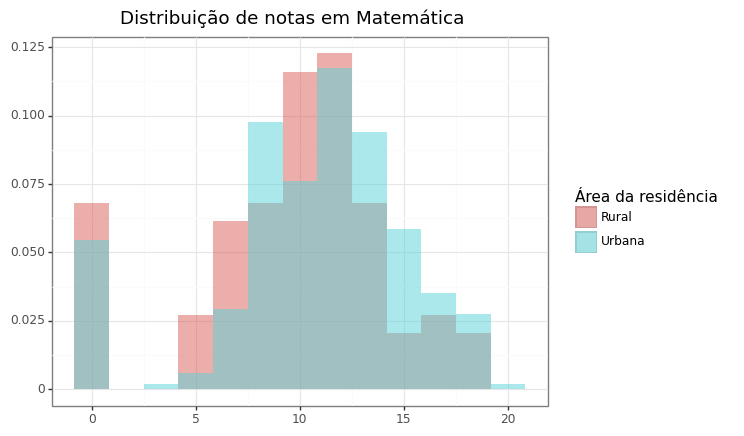

<ggplot: (329216454)>

In [37]:
(
    ggplot(math) +
     geom_histogram(aes(x = "G3", y = "..density.." , fill = "address"), alpha = 0.5,
                   position = "identity") +
     labs(x = "", y = "", title = "Distribuição de notas em Matemática", fill = "Área da residência") +
     scale_fill_discrete(labels = ["Rural", "Urbana"]) 
)


Assim, de forma geral, parece haver uma correlação entre distância da escola e local de residência do aluno com o desempenho em matemática. Aqueles alunos que levam mais tempo para chegar ao colégio e aqueles que moram em zonas rurais parecem ter um desempenho pior do que seus pares quando olha-se para a distribuição das notas.

## Escolaridade dos Pais

Uma outra variável interessante a ser analisada se trata do nível de escolaridade dos pais dos alunos, uma característica que, segundo a literatura de economia da educação, está correlacionada fortemente com o desempenho acadêmico e com os níveis de aprendizado dos jovens. Para isso, olhamos para a nota média dos alunos em matemática segmentando a amostra pelo nível de escolaridade do pai e da mãe. É possível perceber, de fato, uma relação entre o nível de escolaridade atingida pelos pais e o desempenho dos filhos em matemática. No gráfico a seguir vemos claramente como filhos de pais com ensino superior completo possuem um desempenho bastante superior ao de filhos de pais com apenas o Ensino fundamental 1. É importante salientar que fizemos aqui uma equivalência aproximada entre os anos de escolaridade de Portugal e do Brasil para facilitar a análise, uma vez que o ensino básico português não é necessariamente dividido entre ensino fundamental, médio e superior.

In [38]:
father_educ = math.groupby("Fedu", as_index = False).agg(G3_math_mean = ("G3", np.mean))

father_educ = father_educ.query("Fedu != 0")

father_educ["Fedu"] = pd.Categorical(father_educ.Fedu)

In [39]:
mom_educ = math.groupby("Medu", as_index = False).agg(G3_math_mean = ("G3", np.mean))

mom_educ = mom_educ.query("Medu != 0")

mom_educ["Medu"] = pd.Categorical(mom_educ.Medu)

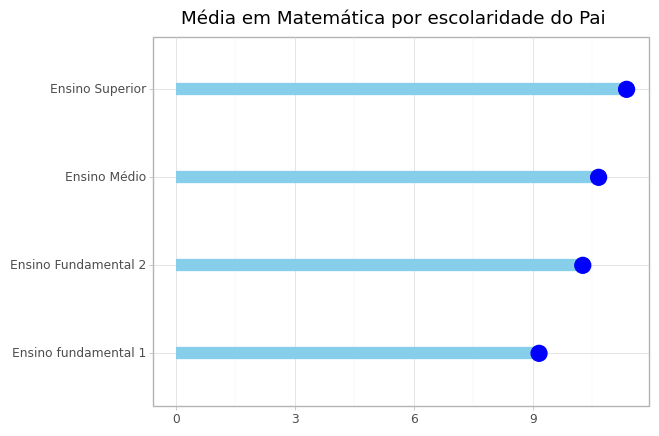

<ggplot: (328149389)>

In [40]:
(
 ggplot(father_educ, aes(x = "Fedu", y = "G3_math_mean")) +
  geom_segment( aes(x = "Fedu", xend = "Fedu", y = 0, yend = "G3_math_mean"), color = "skyblue", size= 5) +
  geom_point(color = "blue", size = 6) +
  theme_light() +
  labs(x = "", y = "", title = "Média em Matemática por escolaridade do Pai") +
  scale_x_discrete(labels = ["Ensino fundamental 1", "Ensino Fundamental 2", "Ensino Médio", "Ensino Superior"]) +
  coord_flip()
)

Focando no nível de escolaridade das mães, conseguimos observar um padrão bem similar àquele que vimos com os pais.

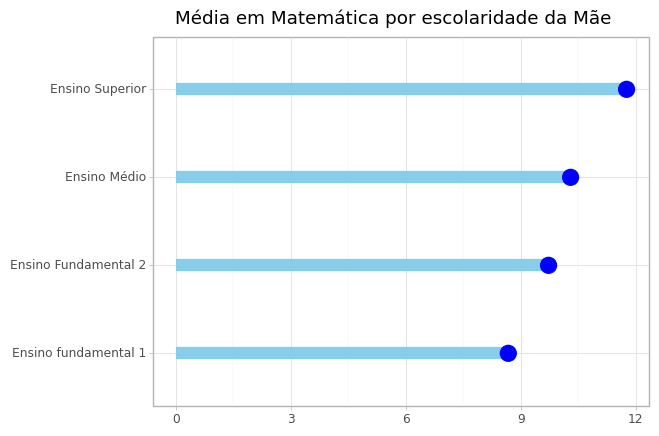

<ggplot: (328149683)>

In [41]:
(
 ggplot(mom_educ, aes(x = "Medu", y = "G3_math_mean")) +
  geom_segment( aes(x = "Medu", xend = "Medu", y = 0, yend = "G3_math_mean"), color = "skyblue", size= 5) +
  geom_point(color = "blue", size = 6) +
  theme_light() +
  labs(x = "", y = "", title = "Média em Matemática por escolaridade da Mãe") +
  scale_x_discrete(labels = ["Ensino fundamental 1", "Ensino Fundamental 2", "Ensino Médio", "Ensino Superior"]) +
  coord_flip()
)

Por fim, olhamos também para uma possível ligação entre a escolaridade da mãe e a relação entre desempenho e faltas dos alunos (similar ao que olhamos na seção sobre localização da residência dos alunos). Quando segmentamos o gráfico de dispersão de desemepenho por número de faltas pelo nível de educação da mãe, percebemos que a relação entre as variáveis se mantém relativamente estável entre os grupos. Isso dá indícios de que a correlação entre faltas e desempenho não é afetada pela escolaridade dos pais.

/var/folders/ny/1pk800191vq8_1r3v97hs5vc0000gq/T/ipykernel_57805/1278904171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


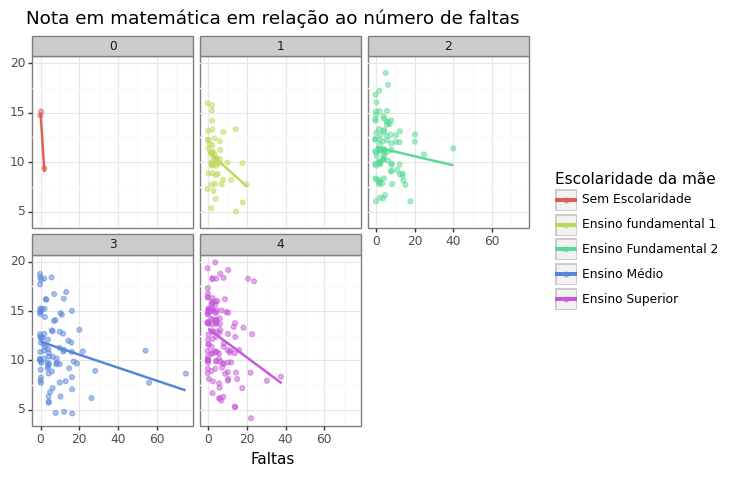

<ggplot: (329342052)>

In [42]:
math_filtered["Medu"] = pd.Categorical(math_filtered.Medu)

(
    ggplot(math_filtered,
        aes(x = "absences", y = "G3", color = "Medu")) +
     geom_point(alpha = 0.5, position = "jitter") +
     geom_smooth(method = "lm", se = False) +
     facet_wrap("~ Medu") +
     labs(x = "Faltas", y = "", 
          title = "Nota em matemática em relação ao número de faltas", 
          color = "Escolaridade da mãe") +
     scale_color_discrete(labels = ["Sem Escolaridade", "Ensino fundamental 1", "Ensino Fundamental 2", "Ensino Médio", "Ensino Superior"])
     )

## Tempo livre após a escola

Vamos observar se podemos identificar algum tipo de relação entre a quantidade de tempo livre que o aluno tem após a escola e suas notas:

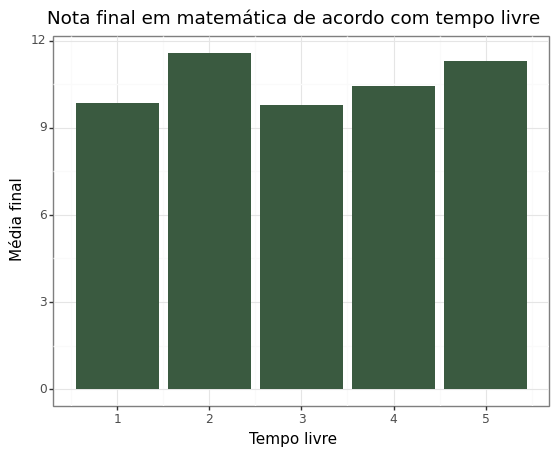

<ggplot: (329574382)>

In [45]:
(math.groupby("freetime")["G3"].mean().reset_index()
 .pipe(lambda _: ggplot(_) +
       geom_col(mapping=aes(x="freetime", y="G3"), fill="#3a5a40") +
       theme_bw() +
       labs(title = "Nota final em matemática de acordo com tempo livre",
            x="Tempo livre",
            y="Média final")))

Aparentemente, não há uma relação clara entre a média final de notas em matemática e o tempo livre dos alunos

Outro ponto interessante que podemos observar é a diferença no tempo livre entre alunos e alunas:

In [46]:
math.groupby(["sex"])["freetime"].mean().reset_index()

,sex,freetime
0,F,3.009615
1,M,3.486631


É possível observar que em média alunos possuem 30 minutos a mais de tempo livre por dia

## Numéro de faltas para alunos que estão em um relacionamento ou não

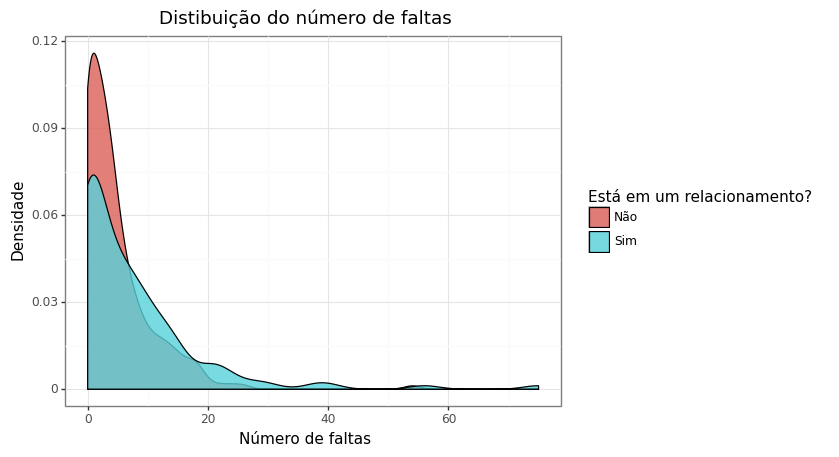

<ggplot: (329511786)>

In [47]:
(math
 .pipe(lambda _: ggplot(_) +
      geom_density(mapping=aes(x="absences", fill="romantic"), alpha = 0.8) +
      theme_bw() +
      labs(title = "Distibuição do número de faltas",
           x = "Número de faltas",
           y = "Densidade",
           fill="Está em um relacionamento?") +
           scale_fill_discrete(labels=["Não", "Sim"])))

Podemos ver pelas distribuições que alunos que estão em um relacionamento faltam mais nas aulas. Será que o fato de estar num relacionamento é o que explica essas faltas?

## Profissão dos pais

Uma dúvida que nos surgiu foi a possibilidade de que filhos de professores performassem melhor em matemática quando comparados a alunos cujos pais exercem outras profissões. Vamos descobrir:

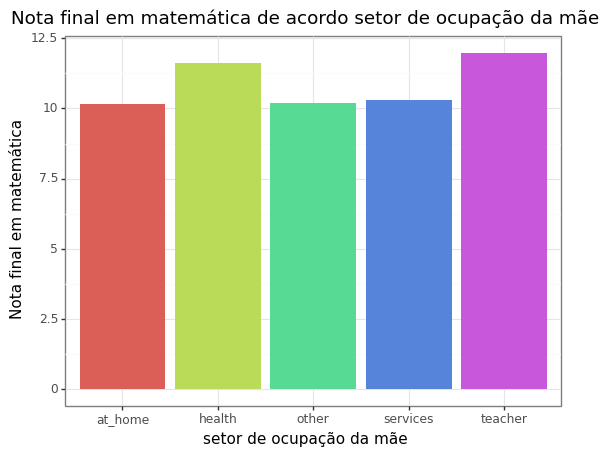

<ggplot: (329573848)>

In [48]:
(math.groupby("Fjob")["G3"].mean().reset_index()
 .pipe(lambda _: ggplot(_) +
      geom_col(mapping=aes(x="Fjob", y="G3", fill="Fjob")) +
      theme_bw() + 
      labs(title = "Nota final em matemática de acordo setor de ocupação da mãe",
           x = "setor de ocupação da mãe",
           y="Nota final em matemática") +
           theme(legend_position="none")))

Podemos ver que claramente, alunos que são filhos de professoras apresentam maiores notas finais em matemática

# Exemplo de uso de modelo preditivo

Vamos supor que os diretores das escolas desejassem promover uma campanha de aulas de reforço particulares para alunos que estajam com altas chances de serem reprovados em matemática no próximo ano. Há apenas 30 vagas para essas aulas especiais. Vamos treinar uma árvore de regressão para prever as notas de G3 com base nas características dos alunos

Vamos usar uma árvore de regressão por conta do n baixíssimo e cross-validação para estimar a acurácia do modelo>

Vamos utilizar as variáveis "sex", "age", "traveltime", "address", "Medu" e "Fedu"

In [49]:
train = math.copy()
X_features = ["sex", "age", "traveltime", "address", "Fedu", "absences"]

In [50]:
train.loc[train["sex"]=="M", "sex"] = 1
train.loc[train["sex"]=="F", "sex"] = 0

train.loc[train["address"]=="U", "address"] = 1
train.loc[train["address"]=="R", "address"] = 0

In [51]:
tree = DecisionTreeRegressor(random_state=27, max_depth=4)
scores = cross_val_score(tree, train[X_features], train["G3"], cv=5, scoring="neg_root_mean_squared_error")
print(abs(scores).mean())

4.38232239882619


Podemos ver que nossa árvore de decisão apresentaria uma raíz do erro quadrático médio igual a 4.38 pontos numa escala de 20 pontos. Vale lembrar que tínhamos uma base com um n muito reduzido.